In [157]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from torchvision import transforms
import cv2

import os
import h5py

In [166]:
DATA_PATH = '/mnt/data2/pushany_rollouts_as_hdf5'
#get list of all directories in 1 levels in DATA_PATH
dirs = [f.name for f in os.scandir(DATA_PATH) if f.is_dir()]
print(dirs)

target_dir = dirs[6]
frame_dir = os.path.join(DATA_PATH, target_dir, 'frames') #frames are saved as tensor .pt files
video_dir = os.path.join(DATA_PATH, target_dir, 'videos')
h5_path = os.path.join(DATA_PATH, target_dir, 'data.h5')

#load h5 file
def load_h5_file(h5_path):
    h5_file = h5py.File(h5_path, 'r')
    return h5_file

h5_file = load_h5_file(h5_path)
print(h5_file.keys())
print(h5_file['action'])
episode_frames_paths = [f.name for f in os.scandir(frame_dir)]

candidate_gap = [1, 40]
selected_episode = episode_frames_paths[60]
frames = torch.load(os.path.join(frame_dir, selected_episode))
print(frames.shape)



['reg4', 'reg3', '8', 'reg5', 'rectangle', '4', '7', 'reg8', '2', '9', 't', 'reg6', 'reg9', '0', 'reg7', '6', '5', 'reg10', 'ellipse', '3', '1']
<KeysViewHDF5 ['action', 'data', 'episode_index', 'frame_index', 'next.done', 'next.reward', 'next.success', 'observation.image', 'observation.state', 'timestamp']>
<HDF5 dataset "action": shape (1500000, 2), type "<f4">
torch.Size([300, 3, 224, 224])


/tmp/ipykernel_1658394/2790991948.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(os.path.join(frame_dir, selected_episode))


In [255]:
DATA_PATH = '/data/dynamo/dynamo_repro_datasets/pusht_dataset/obses'
#get list of all directories in 1 levels in DATA_PATH
episode_paths = [f.name for f in os.scandir(DATA_PATH)]
print(len(episode_paths ))

frames = torch.load(os.path.join(DATA_PATH, episode_paths[10]), map_location='cuda')
frames = frames.permute(0, 3, 1, 2)


206


/tmp/ipykernel_1658394/375569728.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  frames = torch.load(os.path.join(DATA_PATH, episode_paths[10]), map_location='cuda')


In [224]:
model = torch.hub.load('facebookresearch/dinov2', 'dinov2_vits14_reg')
model = model.to('cuda')

Using cache found in /home/jhseon/.cache/torch/hub/facebookresearch_dinov2_main


In [213]:
import sys
sys.path.append('/home/jhseon/projects/dynamo_ssl')

res18_enc = torch.load('/home/jhseon/projects/dynamo_ssl/dynamo_res18_encoder.pt')
res18_enc = res18_enc.to('cuda')

/tmp/ipykernel_1658394/2985874116.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  res18_enc = torch.load('/home/jhseon/projects/dynamo_ssl/dynamo_res18_encoder.pt')


In [253]:
import torchvision

class resnet18(torch.nn.Module):
    def __init__(
        self,
        pretrained: bool = True,
        output_dim: int = 512,  # fixed for resnet18; included for consistency with config
        unit_norm: bool = False,
    ):
        super().__init__()
        resnet = torchvision.models.resnet18(pretrained=pretrained)
        self.resnet = torch.nn.Sequential(*list(resnet.children())[:-1])
        self.flatten = torch.nn.Flatten()
        self.pretrained = pretrained
        self.normalize = torchvision.transforms.Normalize(
            mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        self.unit_norm = unit_norm

    def forward(self, x):
        dims = len(x.shape)
        orig_shape = x.shape
        if dims == 3:
            x = x.unsqueeze(0)
        elif dims > 4:
            # flatten all dimensions to batch, then reshape back at the end
            x = x.reshape(-1, *orig_shape[-3:])
        x = self.normalize(x)
        out = self.resnet(x)
        out = self.flatten(out)
        if self.unit_norm:
            out = torch.nn.functional.normalize(out, p=2, dim=-1)
        if dims == 3:
            out = out.squeeze(0)
        elif dims > 4:
            out = out.reshape(*orig_shape[:-3], -1)
        return out

pretrained_res18 = resnet18(pretrained=True).to('cuda')

/home/jhseon/anaconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/jhseon/anaconda3/envs/lerobot/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [251]:
# Select frames from index 0 to 50

preprocess = transforms.Compose([
    lambda t: t.to(torch.float32) / 255.0,
    transforms.Normalize(mean=[0.485, 0.456, 0.406],  # ImageNet mean
                         std=[0.229, 0.224, 0.225]),  # ImageNet std
])

def get_similarity_matrix(model, frames):
    with torch.no_grad():
        features = model(frames)  # Output shape: [51, feature_dim]

    # Normalize features
    features = F.normalize(features, p=2, dim=-1)  # L2 normalization along feature dimension

    # Compute similarity matrix
    similarity_matrix = torch.mm(features, features.t())  # Shape: [51, 51]
    return features, similarity_matrix



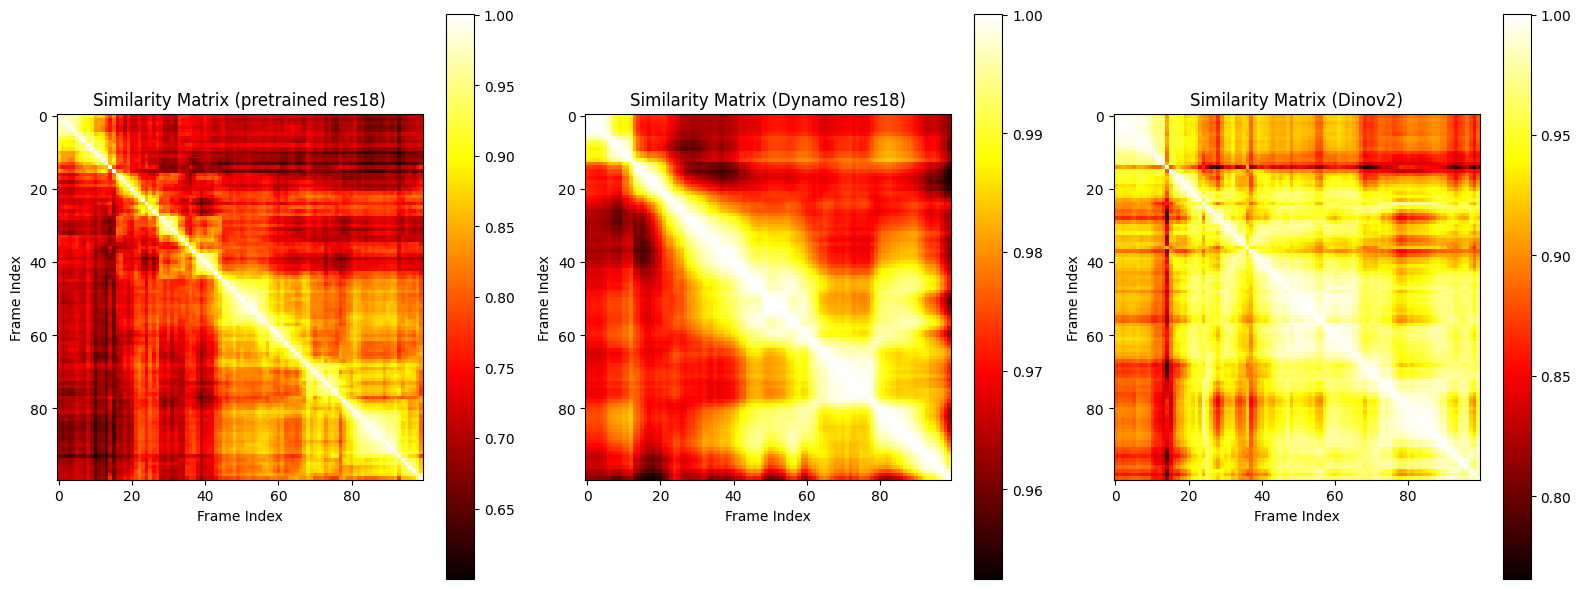

In [256]:
selected_frames = frames[0:100]  # Shape: [100, 3, H, W]

# Apply preprocessing to each frame
preprocessed_frames = preprocess(selected_frames)

# Compute features and similarity matrices for both models
features_res18, similarity_matrix_res18 = get_similarity_matrix(res18_enc, preprocessed_frames)
features_pretrained_res18, similarity_matrix_pretrained_res18 = get_similarity_matrix(pretrained_res18, preprocessed_frames)
features_model, similarity_matrix_model = get_similarity_matrix(model, preprocessed_frames)

# Convert similarity matrices to NumPy arrays for plotting
similarity_matrix_res18_np = similarity_matrix_res18.cpu().numpy()
similarity_matrix_pretrained_res18_np = similarity_matrix_pretrained_res18.cpu().numpy()
similarity_matrix_model_np = similarity_matrix_model.cpu().numpy()

# Plot the similarity matrices side by side
plt.figure(figsize=(16, 6))

# Plot similarity matrix for pretrained_res18
plt.subplot(1, 3, 1)
plt.imshow(similarity_matrix_pretrained_res18_np, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix (pretrained res18)')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')

# Plot similarity matrix for res18_enc
plt.subplot(1, 3, 2)
plt.imshow(similarity_matrix_res18_np, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix (Dynamo res18)')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')

# Plot similarity matrix for model
plt.subplot(1, 3, 3)
plt.imshow(similarity_matrix_model_np, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title('Similarity Matrix (Dinov2)')
plt.xlabel('Frame Index')
plt.ylabel('Frame Index')



plt.tight_layout()
plt.show()


In [145]:
selected_episode = 'observation.image_episode_' + selected_episode.replace('.pt', '.mp4')
video = os.path.join(video_dir, selected_episode)
from IPython.display import Video
Video(video, embed=True)


In [146]:
def get_frames(video_path):
    cap = cv2.VideoCapture(video_path)

    frames = []

    if not cap.isOpened():
        print("Error opening video file")
    else:
        while True:
            ret, frame = cap.read()
            if not ret:
                break
            # 프레임을 BGR에서 RGB로 변환
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            # 프레임을 텐서로 변환하고 리스트에 추가
            frame_tensor = torch.from_numpy(frame)
            frames.append(frame_tensor)

        cap.release()
    return frames

frames = get_frames(video)


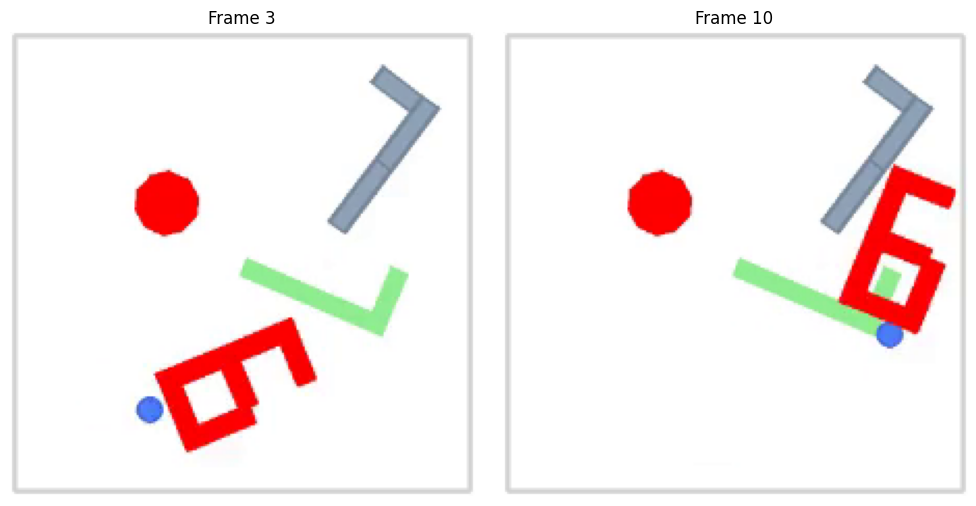

tensor(0.9536)


In [147]:
# 표시할 프레임 인덱스 설정
A_IDX = 3
B_IDX = 10
frame_indices = [A_IDX, B_IDX]  # 원하는 프레임 번호로 변경하세요

# 서브플롯 생성
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# 첫 번째 이미지 표시
axes[0].imshow(frames[frame_indices[0]])
axes[0].set_title(f'Frame {frame_indices[0]}')
axes[0].axis('off')

# 두 번째 이미지 표시
axes[1].imshow(frames[frame_indices[1]])
axes[1].set_title(f'Frame {frame_indices[1]}')
axes[1].axis('off')

# 서브플롯 간 간격 조정
plt.tight_layout()
plt.show()

print(similarity_matrix[A_IDX, B_IDX])


In [156]:
features.shape

torch.Size([300, 384])